In [ ]:

## Loading original MNIST dataset

In [1]:
import os
# turning off annoying tensorflow verbose logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.datasets import mnist

## Loading the cannonical MNIST dataset to use as seed.

Loaginf MNIST using built-in keras routine:


In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Ploting MNIST

Let's check one regular MNIST register:

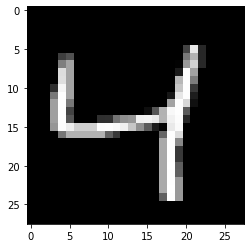

In [3]:
from matplotlib import pyplot

instance = train_X[2]
pyplot.imshow(instance, cmap=pyplot.get_cmap('gray'))
pyplot.show()

## generating 3D digit from 2D

We will stack the original image n times in order to create a 3D grid which is the desired 3D element generated from the 2D original one. A gaussian noise is added to non-zero values in each layer of the stack:

In [5]:
import numpy as np
import random

grid = np.zeros((28, 28, 28))

score = instance / 255.0

zero_min = np.zeros((28, 28))
one_max = np.ones((28, 28))

def gaussian_noise(X, sigma):
    ''' adds a gaussian noise limited to 0 and 1 inclusive'''
    X_nonzero_indexes = np.nonzero(X)
    noise = np.random.normal(0, sigma, X.shape)
    copy = X.copy()
    copy[X_nonzero_indexes] = np.minimum(np.maximum(X[X_nonzero_indexes] + 
        noise[X_nonzero_indexes], zero_min[X_nonzero_indexes]), one_max[X_nonzero_indexes])
    return copy

# generating a 3D instance from a 2D image
for z in range(28):
    instance_points = gaussian_noise(score, 0.2)
    grid[:, :, z] = score

## printing one grid

Let's check our progress by drawing the current state of our 3D element

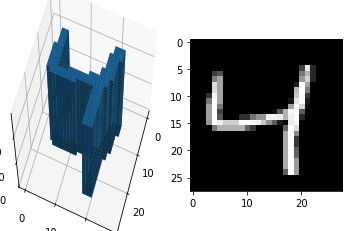

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def print_grid_and_image(grid, image):
    fig = pyplot.figure()

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.azim = 20
    ax.dist = 8
    ax.elev = 60
    ax.voxels(grid)

    ax = fig.add_subplot(1, 2, 2)

    ax.imshow(image, cmap=pyplot.get_cmap('gray'))

    pyplot.show()

print_grid_and_image(grid, score)

## Putting some colors on this!

MNIST instances are grayscale 28x28 images. Real life data is colored. Let's put colors in our 3D data using some random python color map:

In [85]:
color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu']

def convert_to_rgb(gray_image, color_map):
    '''Convert gray image to RGB using the given color map'''
    s_m = pyplot.cm.ScalarMappable(cmap = color_map)
    img_shape = gray_image.shape
    flattened = gray_image.flatten()
    colors = s_m.to_rgba(flattened)
    result = np.zeros(flattened.shape + (3,))

    for i in range(len(flattened)):
        if flattened[i] > 0:
            result[i] = colors[i][:-1]
    return result.reshape(img_shape + (3,))

def create_colored_grid(image, depth, color_map):
    grid = np.zeros(image.shape + (depth, 3,))
    for z in range(depth):
        instance_points = gaussian_noise(image, 0.2)
        rgb_points = convert_to_rgb(instance_points, color_map)
        grid[:, :, z] = rgb_points
    return grid

import random

my_colored_grid = create_colored_grid(score, 28, "viridis")

## plotting 3D digit

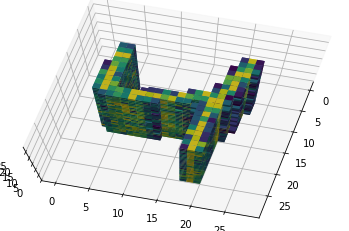

In [99]:
from mpl_toolkits.mplot3d import Axes3D

def print_grid(grid):

    grid_shape = grid.shape

    flattened = grid.reshape(((grid_shape[0] * grid_shape[1] * grid_shape[2]), 3))
    voxel_grid_array = np.zeros(len(flattened))

    for i in range(len(flattened)):
        temp = flattened[i]
        if temp[0] > 0 or temp[1] > 0 or temp[2] > 0:
            voxel_grid_array[i] = 1

    voxel_grid = voxel_grid_array.reshape((grid_shape[0], grid_shape[1], grid_shape[2]))

    fig = pyplot.figure()
    ax = fig.add_subplot(projection='3d')
    ax.azim = 15
    ax.dist = 8
    ax.elev = 75
    ax.voxels(voxel_grid, facecolors=grid)

    pyplot.show()

print_grid(my_colored_grid)

## more transformations: reducing size and rotating

Original images in MNIST are 28x28. Dilatting them to generate cubic grids requires a lot of memory and processing.

1 cube size in bytes: 28 x 28 x 28 x 4
60,000 images: ~5GB

After this step, each image will be resized to 16x16.

In addition, each image is also rotated around ijk axes by random small angles

In [113]:
import math

def rotate(grid, z_ang, y_ang, x_ang):

    grid_shape = grid.shape

    result = np.zeros(grid_shape)

    x_lim = grid_shape[0]
    y_lim = grid_shape[1]
    z_lim = grid_shape[2]

    for i in range(x_lim):
        for j in range(y_lim):
            for k in range(z_lim):

                X = i
                Y = j
                Z = k

                if z_ang != 0:
                    x = i - x_lim / 2
                    y = j - y_lim / 2
                    X = int(math.floor(x*math.cos(z_ang) - y*math.sin(z_ang) + x_lim / 2))
                    Y = int(math.floor(x*math.sin(z_ang) + y*math.cos(z_ang) + y_lim / 2)) 

                if y_ang != 0:
                    x = X - x_lim / 2
                    z = Z - z_lim / 2
                    X = int(math.floor(x*math.cos(y_ang) - z*math.sin(y_ang) + x_lim / 2))
                    Z = int(math.floor(x*math.sin(y_ang) + z*math.cos(y_ang) + z_lim / 2)) 

                if x_ang != 0:
                    y = Y - y_lim / 2
                    z = Z - z_lim / 2
                    Y = int(math.floor(y*math.cos(x_ang) - z*math.sin(x_ang) + y_lim / 2))
                    Z = int(math.floor(y*math.sin(x_ang) + z*math.cos(x_ang) + z_lim / 2)) 

                if X >= 0 and Y >= 0 and Z >= 0 and X < x_lim and Y < y_lim and Z < z_lim:
                    result[X, Y, Z] = grid[i, j, k]

    return result

# Generating the full 3D dataset

In [125]:
import cv2

new_size = 16

rot_in_rad = 20.0 * math.pi / 180.0
half_rot_in_rad = rot_in_rad / 2

def transform_instance(instance):

    resized = cv2.resize(instance, dsize=(new_size, new_size), interpolation=cv2.INTER_CUBIC)

    grid = create_colored_grid(resized / 255.0, new_size, random.choice(color_maps))

    z_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    y_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    x_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    result = rotate(grid, z_rot, y_rot, x_rot)

    return result

train_X_3D = np.zeros((len(train_X), new_size, new_size, new_size, 3))
test_X_3D = np.zeros((len(test_X), new_size, new_size, new_size, 3))
        
for i in range(len(train_X)):
    train_X_3D[i] = transform_instance(train_X[i])

for i in range(len(test_X)):
    test_X_3D[i] = transform_instance(test_X[i])
        

## print some instances

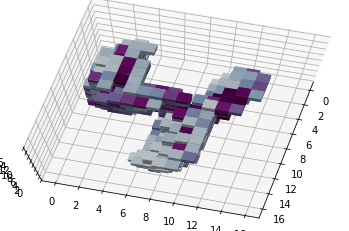

In [127]:

print_grid(train_X_3D[2])

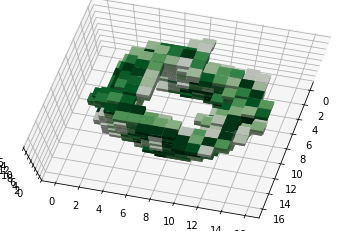

In [130]:
print_grid(train_X_3D[108])

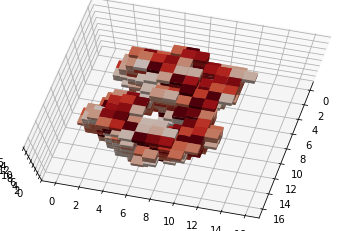

In [131]:
print_grid(train_X_3D[404])

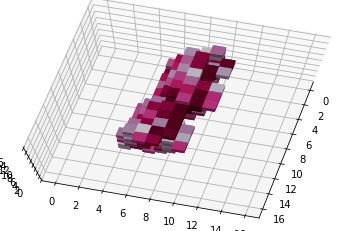

In [133]:
print_grid(test_X_3D[14])

## Training

In [134]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical

In [135]:
# Convert target vectors to categorical targets
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [136]:
def define_model():
	model = Sequential()
	model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=test_X_3D[0].shape))
	model.add(MaxPooling3D(pool_size=(2, 2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	return model

## training

In [16]:

model = define_model()

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                metrics=['accuracy'])

history = model.fit(train_X_3D, train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
1500/1500 [==============================] - 752s 431ms/step - loss: 0.2867 - accuracy: 0.9128 - val_loss: 0.1242 - val_accuracy: 0.9624
Epoch 2/4
1500/1500 [==============================] - 632s 421ms/step - loss: 0.0882 - accuracy: 0.9718 - val_loss: 0.0879 - val_accuracy: 0.9742
Epoch 3/4
1500/1500 [==============================] - 651s 434ms/step - loss: 0.0595 - accuracy: 0.9805 - val_loss: 0.1005 - val_accuracy: 0.9707
Epoch 4/4
1500/1500 [==============================] - 679s 453ms/step - loss: 0.0389 - accuracy: 0.9869 - val_loss: 0.0964 - val_accuracy: 0.9740


## Checking model

In [23]:
score = model.evaluate(test_X_3D, test_y, verbose=0)
print('Test accuracy: %.2f%% Test loss: %.3f' % (score[1]*100, score[0]))


Test accuracy: 97.480% Test loss: 0.083
